# Mini Project: Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

In [1]:
"""
This is a simple implementation of the Gridworld Cliff
reinforcement learning task.
Adapted from Example 6.6 from Reinforcement Learning: An Introduction
by Sutton and Barto

With inspiration from:
https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py
The board is a 4x12 matrix, with (using Numpy matrix indexing):
    [3, 0] as the start at bottom-left
    [3, 11] as the goal at bottom-right
    [3, 1..10] as the cliff at bottom-center
Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward 
and a reset to the start. An episode terminates when the agent reaches the goal.
"""

'\nThis is a simple implementation of the Gridworld Cliff\nreinforcement learning task.\nAdapted from Example 6.6 from Reinforcement Learning: An Introduction\nby Sutton and Barto\n\nWith inspiration from:\nhttps://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py\nThe board is a 4x12 matrix, with (using Numpy matrix indexing):\n    [3, 0] as the start at bottom-left\n    [3, 11] as the goal at bottom-right\n    [3, 1..10] as the cliff at bottom-center\nEach time step incurs -1 reward, and stepping into the cliff incurs -100 reward \nand a reset to the start. An episode terminates when the agent reaches the goal.\n'

### Part 0: Explore CliffWalkingEnv

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
import gym
from IPython.display import Image
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
# print the state space and action space
print(env.observation_space)
print(env.action_space)

# print the total number of states and actions
print(env.nS)
print(env.nA)

Discrete(48)
Discrete(4)
48
4


#### Optimal state-value function

In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the **optimal state-value function**.

Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward 

In [4]:
import numpy as np
from plot_utils import plot_values

# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 1500x500 with 1 Axes>

### Part 1: TD Prediction: State Values

TD(0) is guaranteed to converge to the true state-value function, as long as the step-size parameter α(ALPHA) is sufficiently small. If you recall, this was also the case for **constant-α MC prediction**. However, TD(0) has some nice **advantages**:
- Whereas MC prediction must wait until the end of an episode to update the value function estimate, TD prediction methods update the value function after every time step. Similarly, TD prediction methods work for continuous and episodic tasks, while MC prediction can only be applied to episodic tasks.
- In practice, TD prediction converges faster than MC prediction. (That said, no one has yet been able to prove this, and it remains an open problem.) You are encouraged to take the time to check this for yourself in your implementations! For an example of how to run this kind of analysis, check out Example 6.2 in the Reinforcemer learning text book.


In this section, you will write your own implementation of TD prediction (for estimating the state-value function).

We will begin by investigating a policy where the agent moves:
- `RIGHT` in states `0` through `10`, inclusive,  
- `DOWN` in states `11`, `23`, and `35`, and
- `UP` in states `12` through `22`, inclusive, states `24` through `34`, inclusive, and state `36`.

#### Testing policy
The policy is specified and printed below.  Note that states where the agent does not choose an action have been marked with `-1`.

In [5]:
policy = np.hstack([1*np.ones(11), 2, 0, np.zeros(10), 2, 0, np.zeros(10), 2, 0, -1*np.ones(11)])
print("\nPolicy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy.reshape(4,12))


Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]


Run the next cell to visualize **the state-value function** that corresponds to this policy.  Make sure that you take the time to understand why this is the corresponding value function!

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


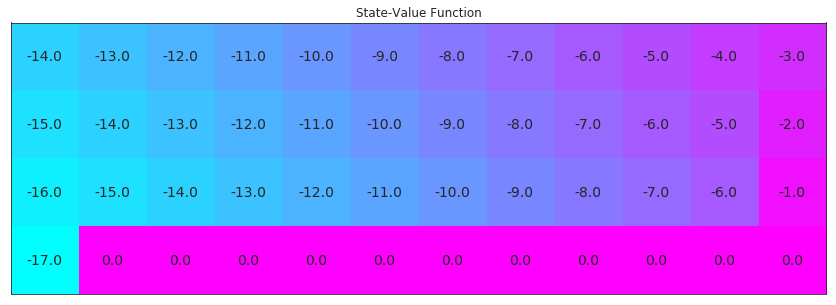

In [6]:
V_true = np.zeros((4,12))

for i in range(3):
    # np.arange(3, 15)[::-1] # equals [14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3]
    V_true[0:12][i] = -np.arange(3, 15)[::-1] - i
    
V_true[1][11] = -2
V_true[2][11] = -1
V_true[3][0] = -17

plot_values(V_true)

The above figure is what you will try to approximate through the TD prediction algorithm.

In [7]:
# Getting comfortable with the environement

# trying the first step:
# - resets the state to the starting point
# - then get the action from the policy
# - give the action to the environments step function and see what you get

def testing_playground(policy):
    # reset the environment
    state = env.reset()

    # get the action from the policy
    action = policy[state]

    # perform a step on the environment with that action
    step = env.step(action)

    print("Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
    print("\n--> trying first steps:")
    print("State: {}\nAction: {}\nResulting step: {}".format(state, action, step))

    # running a full episode
    # do the above until the step brings back, that we are done
    print("\n--> now running a full episode:")

    # reset the environment
    state = env.reset()
    while True:
        # perform the next step
        action = policy[state]
        state, reward, episode_end, probs = env.step(action)
        print(state, reward, episode_end, probs)

        # break when the episode ended
        if episode_end:
            break



print("-"*10 + "Testing testing policy" + "-"*10 )
testing_playground(policy)

# ================Fail example===================
"""
24 -1 False {'prob': 1.0}
25 -1 False {'prob': 1.0}
36 -100 False {'prob': 1.0}  <===== Reward -100, Agent start again
24 -1 False {'prob': 1.0} <==== Start at bottom left conor, state 24 again...
24 -1 False {'prob': 1.0}
25 -1 False {'prob': 1.0} <====.... continue the looop...


print("-"*10 + "Testing fail policy" + "-"*10 )
fail_policy = np.hstack([1*np.zeros(24), 1, 2, np.zeros(10), 0, -1*np.ones(11)])
print("\nPolicy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(fail_policy.reshape(4,12))
testing_playground(fail_policy)

"""

----------Testing testing policy----------
Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):

--> trying first steps:
State: 36
Action: 0.0
Resulting step: (24, -1, False, {'prob': 1.0})

--> now running a full episode:
24 -1 False {'prob': 1.0}
12 -1 False {'prob': 1.0}
0 -1 False {'prob': 1.0}
1 -1 False {'prob': 1.0}
2 -1 False {'prob': 1.0}
3 -1 False {'prob': 1.0}
4 -1 False {'prob': 1.0}
5 -1 False {'prob': 1.0}
6 -1 False {'prob': 1.0}
7 -1 False {'prob': 1.0}
8 -1 False {'prob': 1.0}
9 -1 False {'prob': 1.0}
10 -1 False {'prob': 1.0}
11 -1 False {'prob': 1.0}
23 -1 False {'prob': 1.0}
35 -1 False {'prob': 1.0}
47 -1 True {'prob': 1.0}


'\n24 -1 False {\'prob\': 1.0}\n25 -1 False {\'prob\': 1.0}\n36 -100 False {\'prob\': 1.0}  <===== Reward -100, Agent start again\n24 -1 False {\'prob\': 1.0} <==== Start at bottom left conor, state 24 again...\n24 -1 False {\'prob\': 1.0}\n25 -1 False {\'prob\': 1.0} <====.... continue the looop...\n\n\nprint("-"*10 + "Testing fail policy" + "-"*10 )\nfail_policy = np.hstack([1*np.zeros(24), 1, 2, np.zeros(10), 0, -1*np.ones(11)])\nprint("\nPolicy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")\nprint(fail_policy.reshape(4,12))\ntesting_playground(fail_policy)\n\n'

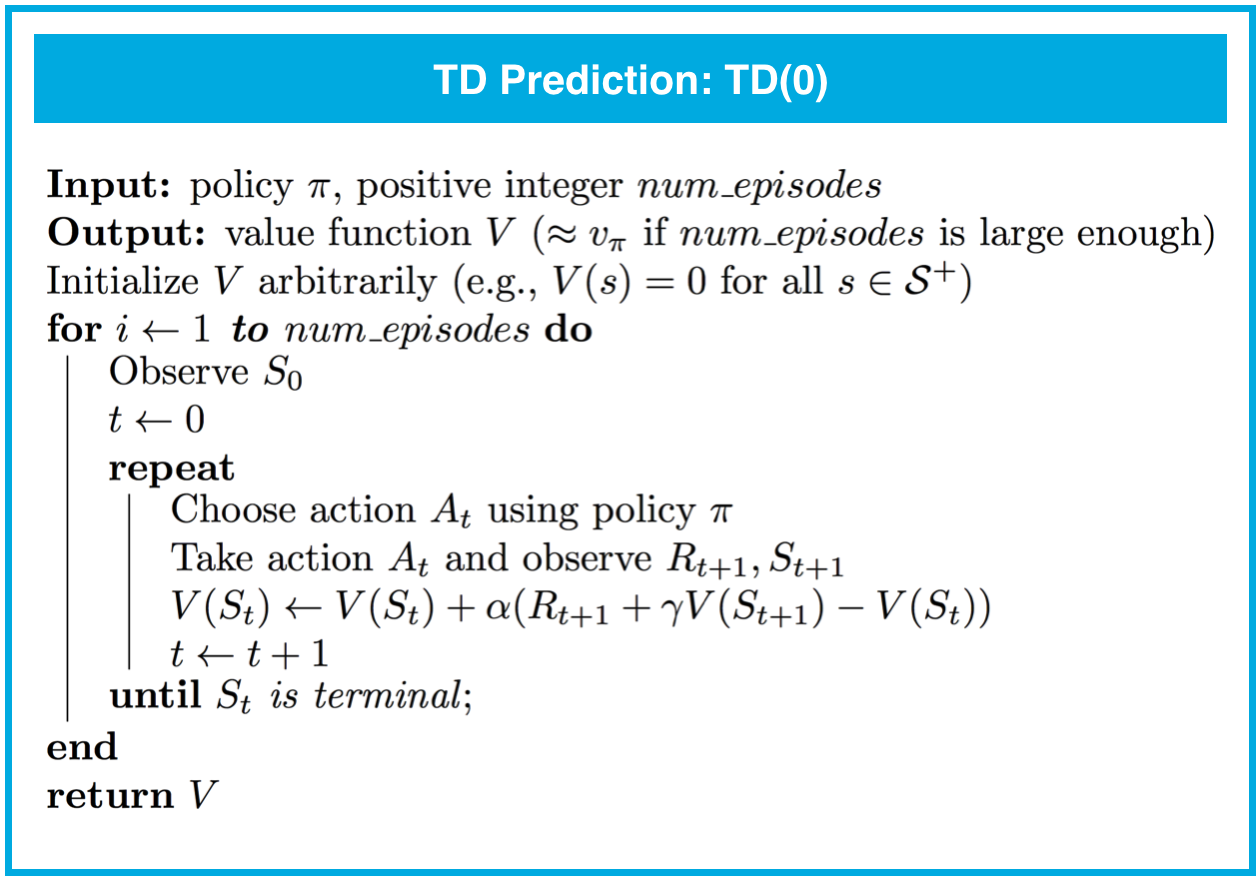

In [8]:
Image(filename='img/td-prediction.png', width=700)

Your algorithm for TD prediction has five arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `policy`: This is a 1D numpy array with `policy.shape` equal to the number of states (`env.nS`).  `policy[s]` returns the action that the agent chooses when in state `s`.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.

Please complete the function in the code cell below.

In [9]:
from collections import defaultdict, deque
import sys

def td_prediction(env, num_episodes, policy, alpha, gamma=1.0):
    
    # initialize V as a empty dictionaries of floats
    V = defaultdict(float)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # begin an episode by resetting the environment, observe S
        state = env.reset()
        
        # go through the episode
        while True:
            
            # choose action A
            action = policy[state]
            
            # take action A, observe R, S'
            next_state, reward, done, info = env.step(action)
            
            # ====================== perform updates ====================== 
            # now immediately update the state function in every step with that
            # steps reward + the discounted next steps reward 
            # use whatever state function you have for each state to calculate the
            # updata
            V[state] = V[state] + (alpha * (reward + (gamma * V[next_state]) - V[state]))
            
            # Set the state to the next state in order to continue the episode
            # S <- S'
            state = next_state
            
            # end episode if reached terminal state
            if done:
                break 
                
    # finally return the approximated state function for the policy
    return V

Run the code cell below to test your implementation and visualize the estimated state-value function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

**<span style="color: green;">PASSED</span>**

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


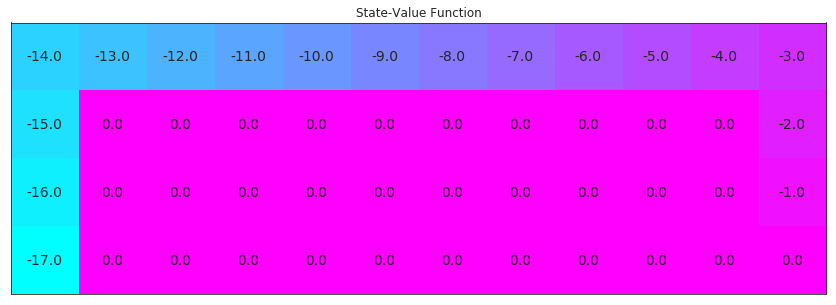

In [10]:
import check_test

# evaluate the policy and reshape the state-value function
V_pred = td_prediction(env, 5000, policy, .01)

# please do not change the code below this line
V_pred_plot = np.reshape([V_pred[key] if key in V_pred else 0 for key in np.arange(48)], (4,12)) 
check_test.run_check('td_prediction_check', V_pred_plot)
plot_values(V_pred_plot)

How close is your estimated state-value function to the true state-value function corresponding to the policy?  

You might notice that some of the state values are not estimated by the agent.  This is because under this policy, the agent will not visit all of the states.  In the TD prediction algorithm, the agent can only estimate the values corresponding to states that are visited.

### Part 2: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

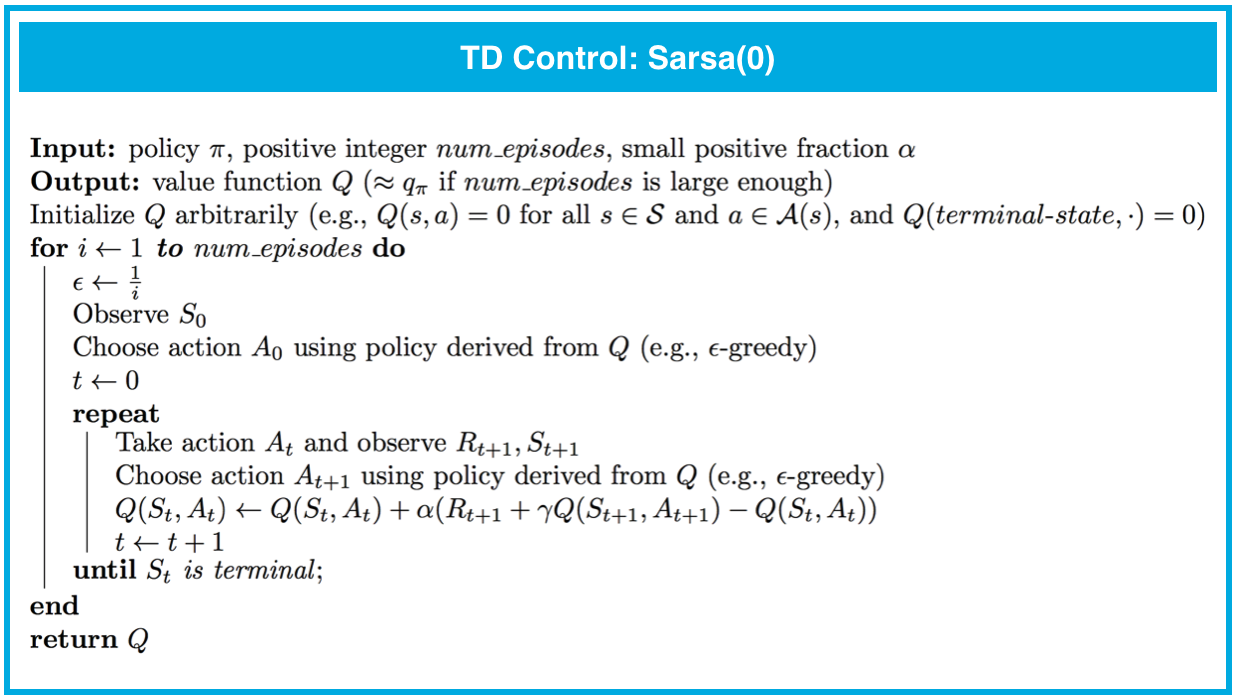

In [11]:
Image(filename='img/sarsa.png', width=700)

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [12]:
def update_Q(Qsa, Qsa_next, reward, alpha, gamma):
    """ updates the action-value function estimate using the most recent time step """
    return Qsa + (alpha * (reward + (gamma * Qsa_next) - Qsa))

def epsilon_greedy_probs(env, Q_s, i_episode, eps=None):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    epsilon = 1.0 / i_episode
    if eps is not None:
        epsilon = eps
    policy_s = np.ones(env.nA) * epsilon / env.nA
    policy_s[np.argmax(Q_s)] = 1 - epsilon + (epsilon / env.nA)
    return policy_s

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

def sarsa(env, num_episodes, alpha, gamma=1.0):
    
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # Sai: Set epsilon to .1 for comparison at Final Section!
    epsilon = .1
    
    # initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
            
        # initialize score
        score = 0
        
        # S1: begin an episode, observe S
        state = env.reset()   
        
        # get epsilon-greedy action probabilities
        policy_s = epsilon_greedy_probs(env, Q[state], i_episode, epsilon)
        
        # A1: pick action 
        action = np.random.choice(np.arange(env.nA), p=policy_s)
        
        # limit number of time steps per episode
        for t_step in np.arange(300):
            
            # take action A, observe R, S'
            next_state, reward, done, info = env.step(action)
            
            # add reward to score
            score += reward
            if not done:
                
                # get epsilon-greedy action probabilities
                policy_s = epsilon_greedy_probs(env, Q[next_state], i_episode, epsilon)
                
                # pick next action A'
                next_action = np.random.choice(np.arange(env.nA), p=policy_s)
                
                # update TD estimate of Q
                Q[state][action] = update_Q(Q[state][action], Q[next_state][next_action], 
                                            reward, alpha, gamma)
                # S <- S'
                state = next_state
                
                # A <- A'
                action = next_action
                
            if done:
                # update TD estimate of Q
                Q[state][action] = update_Q(Q[state][action], 0, reward, alpha, gamma)
                # append score
                tmp_scores.append(score)
                break
                
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    return Q, scores

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

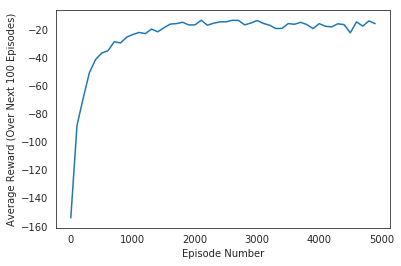

Best Average Reward over 100 Episodes:  -13.1


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  2  1  1  2  1  2  1  1  2  2]
 [ 1  0  3  1  1  1  2  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


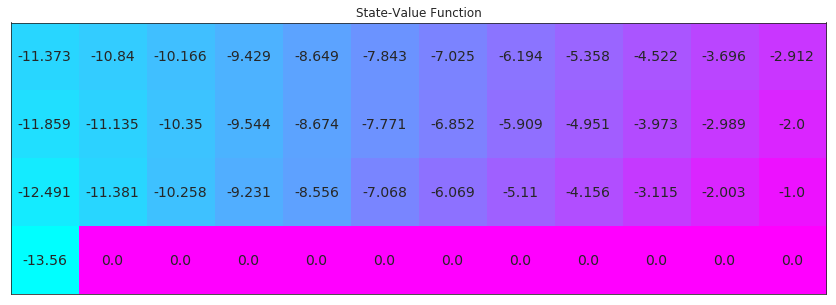

In [69]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa, Q_sarsa_scores = sarsa(env, 5000, .02)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 3: TD Control: Sarsamax (Q-learning)

In this section, you will write your own implementation of the Q-learning control algorithm.

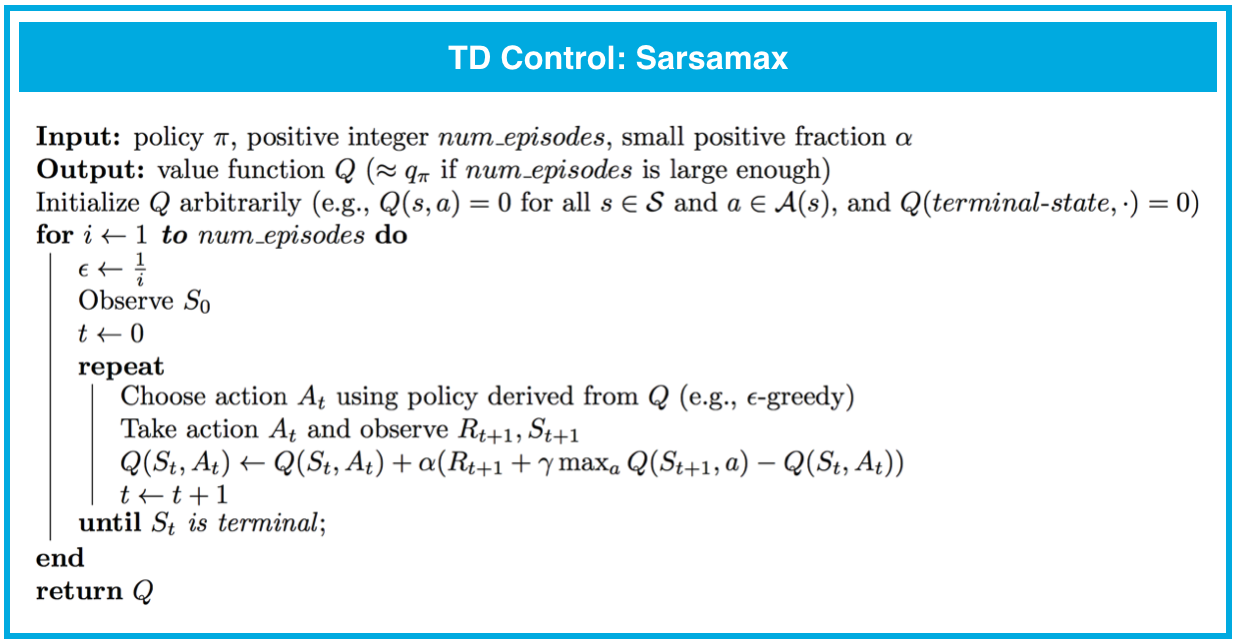

In [32]:
Image(filename='img/sarsamax.png', width=700)

#### Sarasa VS Sarsamax (Q-Learning)
The main difference between Sarasa and Sarsamax(Q-Learning) is...

Sarsa
In Sarsa, the update step pushes the action values closer to evaluating whatever Epsilon greedy policy is currently being followed by the agent. 
**用下一步既State + 下一步既Action 放入Epsilon greedy policy**

Sarsamax
Sarsamax instead, directly attempts to approximate the optimal value function at every time step.
**用下一步既State + 今步既Action 放入Epsilon greedy policy，最後用max 去計**

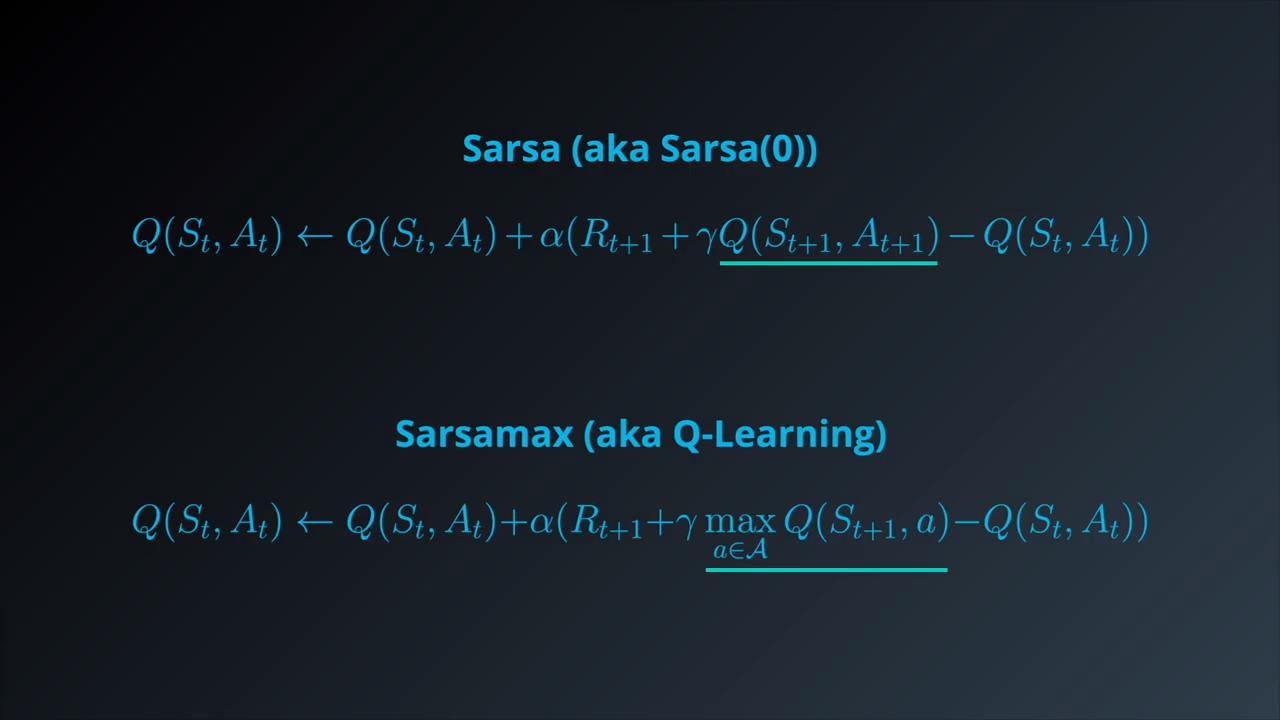

In [33]:
Image(filename='img/from_sarasa_to_sarsamax.png', width=700)

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [150]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # Sai: Set epsilon to .1 for comparison at Final Section!
    epsilon = .1
        
    # initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # initialize score
        score = 0
        
        # S1: begin an episode, observe S
        state = env.reset()
        
        while True:
            
            # get epsilon-greedy action probabilities
            policy_s = epsilon_greedy_probs(env, Q[state], i_episode, epsilon)
            
            # pick next action A
            action = np.random.choice(np.arange(env.nA), p=policy_s)
            
            # take action A, observe R, S'
            next_state, reward, done, info = env.step(action)
            
            # add reward to score
            score += reward
            
            # =========== update Q in Q_learning! [Important] ===========
            # The one action that maximizes the action value estimate 
            # corresponding to the next stat
            Q[state][action] = update_Q(
                Q[state][action], 
                np.max(Q[next_state]),  # <=== The main difference compares to Sarasa!
                reward, alpha, gamma)
            
            # =========== update Q in Sarasa!! ===========
            # update_Q(Q[state][action], 
            #         Q[next_state][next_action], 
            #         reward, alpha, gamma)
            
            
            # S <- S'
            state = next_state
            
            # until S is terminal
            if done:
                # append score
                tmp_scores.append(score)
                break
                
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    return Q, scores

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

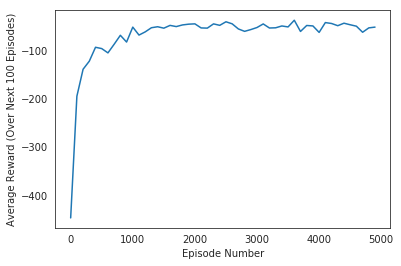

Best Average Reward over 100 Episodes:  -36.87


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  2  1  1  1  2  2]
 [ 3  1  0  2  1  1  1  1  2  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


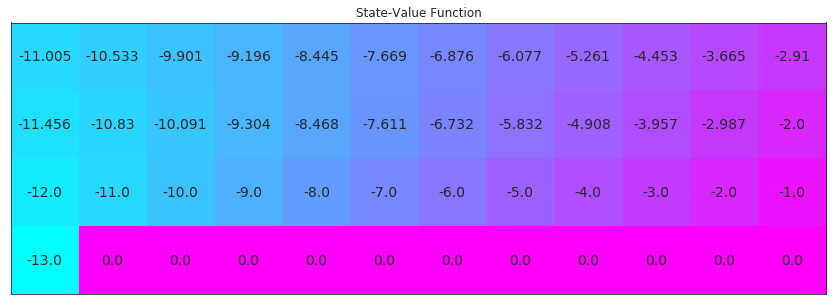

In [151]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax, Q_sarsamax_scores = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 4: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

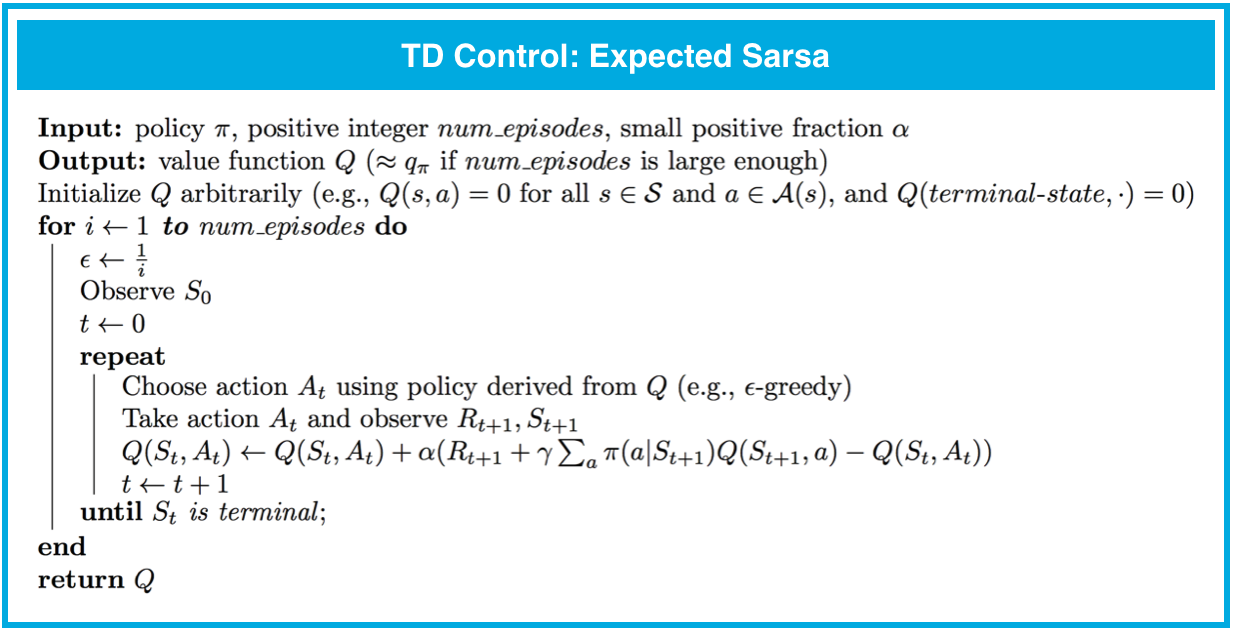

In [76]:
Image(filename='img/expected-sarsa.png', width=700)

#### Sarsamax (Q-Learning) VS Expected Sarsa

**Sarsamax**
Remember that Sarsamax or Q learning took the maximum over all actions of all possible **next state-action pairs**. In other words, it chooses what value to place here(Sarsamax yellow underlined below) by *plugging in the one action that maximizes the action value estimate corresponding to the next state*. 

**Expected Sarsa** 
Expected Sarsa does something a bit different. It uses the **expected value** of the **next-state action pair**, where the expectation takes into account the probability that the agent selects each possible action from the next state. 

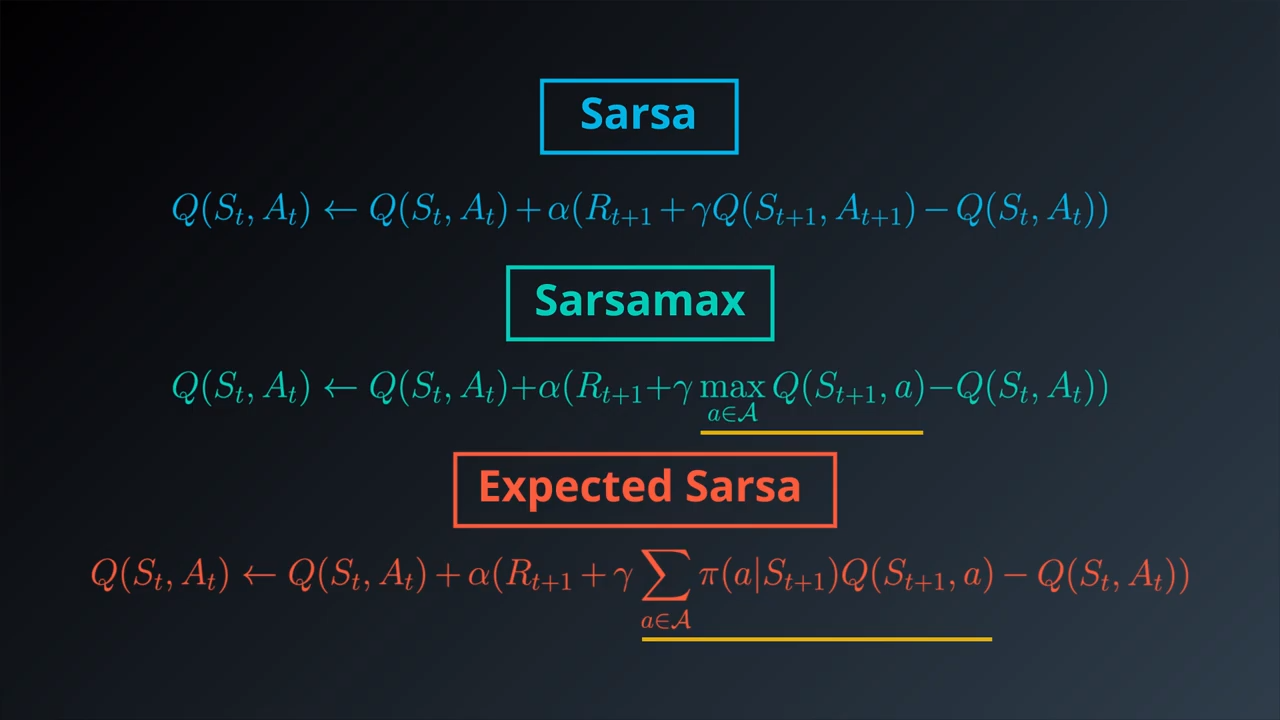

In [77]:
Image(filename='img/expected_sarsa.png', width=700)

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [148]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # initialize score
        score = 0
        
        # begin an episode
        state = env.reset()
        
        # get epsilon-greedy action probabilities
        policy_s = epsilon_greedy_probs(env, Q[state], i_episode, .005)
        
        while True:
            
            # pick next action A
            action = np.random.choice(np.arange(env.nA), p=policy_s)
            
            # take action A, observe R, S'
            next_state, reward, done, info = env.step(action)
            
            # add reward to score
            score += reward
            
            # get epsilon-greedy action probabilities (for S')
            policy_s = epsilon_greedy_probs(env, Q[next_state], i_episode, .005)
            
            # =========== update Q in Expected Sarsa! [Important] ===========
            # The expectation takes into account the probability that 
            # the agent selects each possible action from the next state. 
            Q[state][action] = update_Q(
                Q[state][action], 
                np.dot(Q[next_state], policy_s),  # <=== The main difference compares to Q-Leanring!
                reward, alpha, gamma)
            
            # =========== update Q in Q_learning! ===========
            # The one action that maximizes the action value estimate 
            # corresponding to the next stat
            # Q[state][action] = update_Q(
            #    Q[state][action], 
            #    np.max(Q[next_state]), 
            #    reward, alpha, gamma)
            
            # S <- S'
            state = next_state
            
            # until S is terminal
            if done:
                
                # append score
                tmp_scores.append(score)
                break
                
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    return Q, scores

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

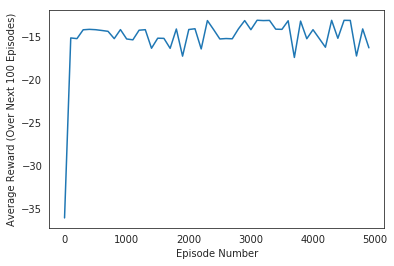

Best Average Reward over 100 Episodes:  -13.04


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  1  1  1  1  0  1  1  1  1  1  0]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


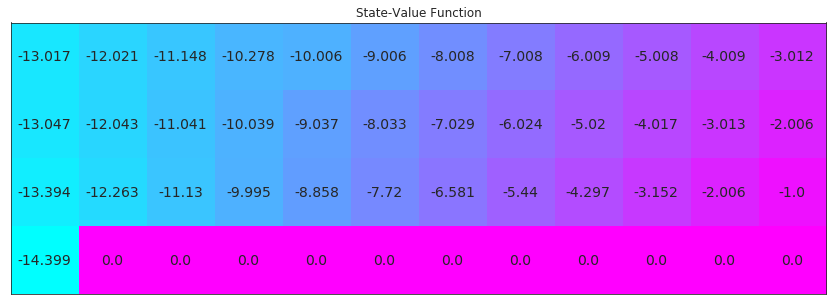

In [149]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa, Q_expsarsa_scores = expected_sarsa(env, 5000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])

# Analyzing Performance by Sai

All of the TD control algorithms we have examined (Sarsa, Sarsamax, Expected Sarsa) converge to the optimal action-value function q∗ (and so yield the optimal policy π∗ if (1) the value of ϵ decays in accordance with the GLIE conditions, and (2) the step-size parameter α is sufficiently small.
The differences between these algorithms are summarized below:
- Sarsa and Expected Sarsa are both **on-policy** TD control algorithms. In this case, the same (ϵ-greedy) policy that is evaluated and improved is also used to select actions.

- Sarsamax is an **off-policy** method, where the (greedy) policy that is evaluated and improved is different from the (ϵ-greedy) policy that is used to select actions.

- On-policy TD control methods (like Expected Sarsa and Sarsa) have better online performance than off-policy TD control methods (like Sarsamax).

- Expected Sarsa generally achieves better performance than Sarsa.


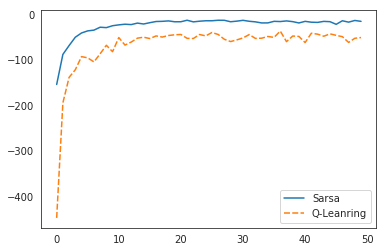

In [153]:
import seaborn as sns; # sns.set()
import pandas as pd


def compare_difference_TD(Q_sarsa_scores, Q_sarsamax_scores, Q_expsarsa_scores):
    
    num_episodes = 5000
    plot_every = 100
    total_show_episodes = int(num_episodes/plot_every)
    
    Q_sarsa_scores = np.asarray(list(Q_sarsa_scores), dtype=np.float32)
    Q_sarsamax_scores = np.asarray(list(Q_sarsamax_scores), dtype=np.float32)
    #Q_expsarsa_scores = np.asarray(list(Q_expsarsa_scores), dtype=np.float32)
    
    #scores = np.column_stack((Q_sarsa_scores, Q_sarsamax_scores, Q_expsarsa_scores))
    scores = np.column_stack((Q_sarsa_scores, Q_sarsamax_scores))
    

    #wide_df = pd.DataFrame(scores, pd.RangeIndex(0,total_show_episodes), ["Sarsa", "Q-Leanring", "Expected-Sarsa"])
    wide_df = pd.DataFrame(scores, pd.RangeIndex(0,total_show_episodes), ["Sarsa", "Q-Leanring"])
    ax = sns.lineplot(data=wide_df)
    #ax.set(ylim=(-50, None))

compare_difference_TD(Q_sarsa_scores, Q_sarsamax_scores, Q_expsarsa_scores)

## Reproduce successfully!

**Sai**: Yeah! I can reproduce the below figure from the text book of Reinforcement Learning by Richard S. Sutton and Andrew G. Barto - (Example 6.6: Cliff Walking)

The figure shows the performance of Sarsa and Q-learning on the cliff walking environment for constant ϵ=0.1. As described in the textbook, in this case,

- Q-learning achieves worse online performance (where the agent collects less reward on average in each episode), but learns the optimal policy, and
- Sarsa achieves better online performance, but learns a sub-optimal "safe" policy.

#### Conclusion

After an initial transient, **Q-Learning** learns values for the optimal policy, that which travels right along the edge of the cliff. Unfortunately, this results in its occcasionally falling off the cliff because of the ϵ-greedy action selection. **Sarsa**, on the other hand, takes the action seclection into account and learns the longer but safer path through the upper part of the grid.

Although **Q-learning** actually learns the values of the optimal policy, its online performance is worse than that of Sarsa, which learns the roundabout policy.

Of course, if ϵ were gradually reduced, then both methods would asymptotically converge to the optimal policy.

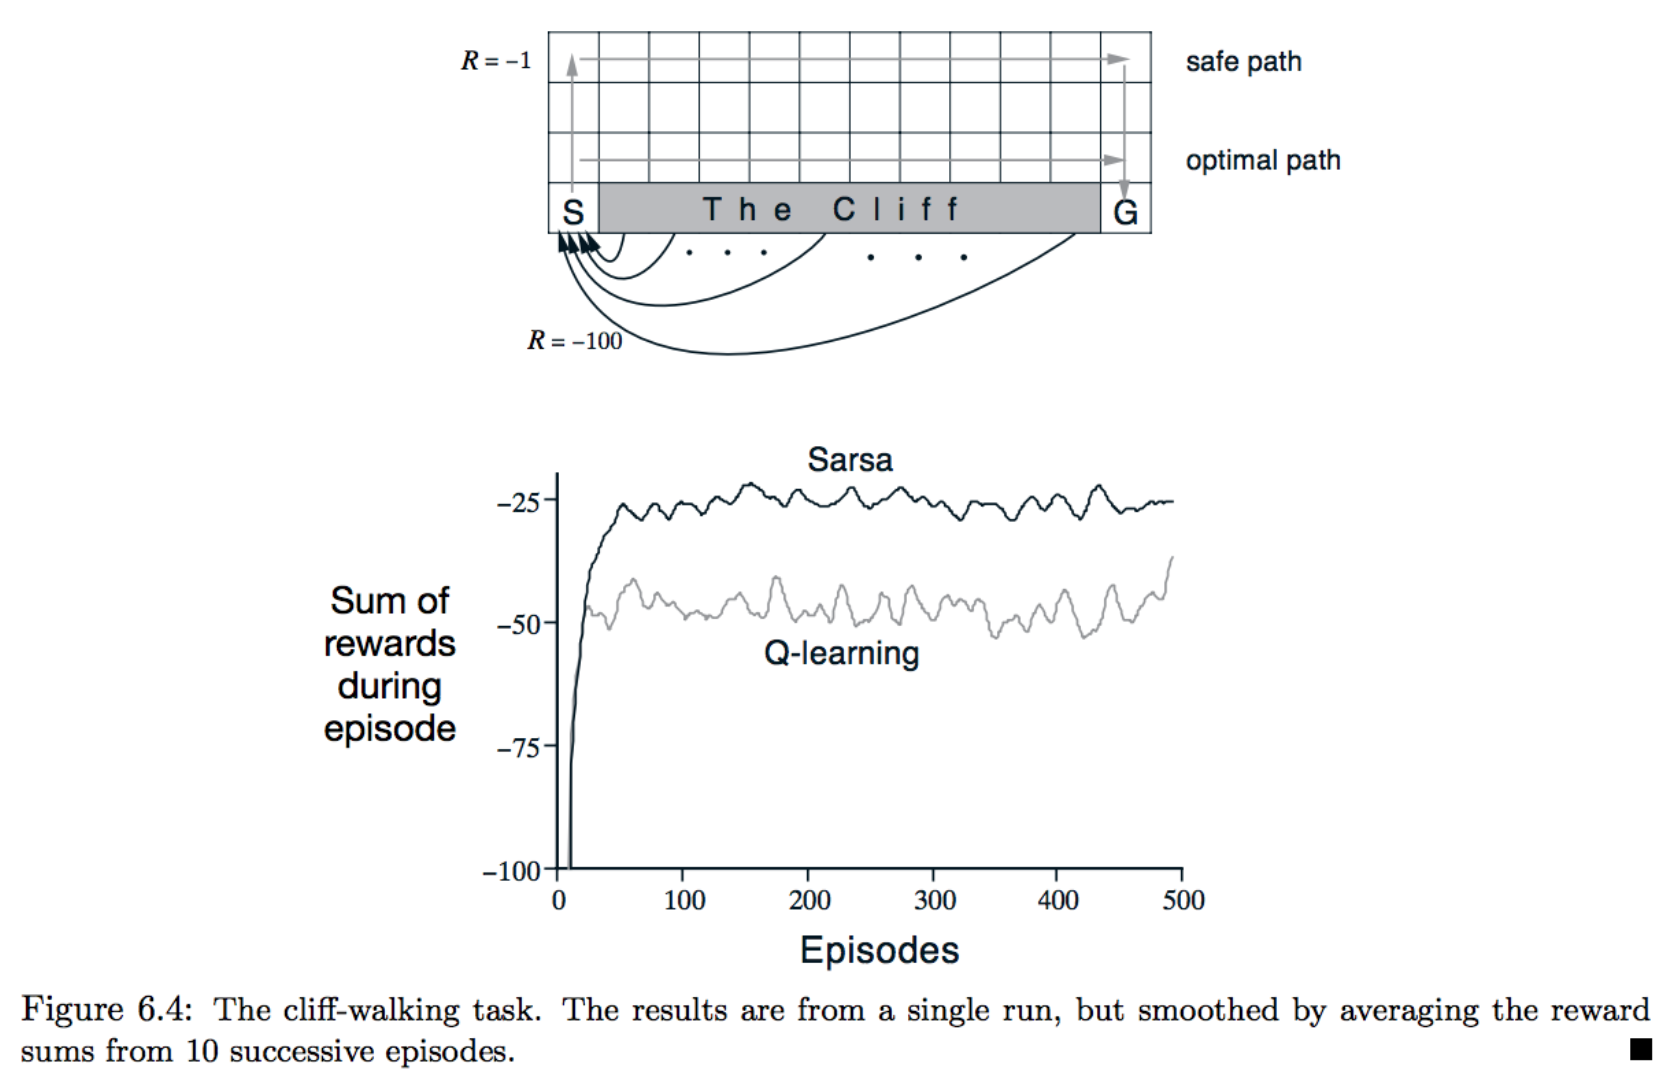

In [41]:
Image(filename='img/screen-shot-from-textbook.png', width=700)